In this notebook, we will go over an implementation of backpropagation for a multilayer densely connected neural network using Numpy. 

 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

if not os.path.isdir('MATH448001'):
    !git clone https://github.com/CihanSoylu/MATH448001.git

from MATH448001.project_utils import project_2_utils

Cloning into 'MATH448001'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 226 (delta 135), reused 160 (delta 71), pack-reused 0
Receiving objects: 100% (226/226), 1.72 MiB | 17.63 MiB/s, done.
Resolving deltas: 100% (135/135), done.


We will denote the layer variables (e.g. weights of the layer, outputs of the layer) by an upperscript inside square brackets `[]`. For example, $W^{[k]}$ is the weight matrix of the kth layer. 

Let's start with a function that initialize the weights and biases. This is simply what you did for Project 2, now for multiple layers. The below function will return a [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) with keys `weights` and  `biases` where the values for the keys are the [lists](https://docs.python.org/3.7/tutorial/introduction.html?highlight=list#lists) of weight matrices and biases. If `layer_sizes` are $n_0, n_1, \ldots, n_l$ where $n_0$ is the input dimension and $n_l$ is the output dimension and $l$ is the number of layers, then the weights will be a list $[W^{[1]}, W^{[2]}, \ldots, W^{[l]}]$ where $W^{[k]}$ has dimension $n_{k-1}\times n_{k}$ and the biases will be a list $[b^{[1]}, b^{[2]}, \ldots, b^{[l]}]$ where $b^{[k]}$ has dimension $1\times n_k$. 


In [0]:
def initialize_weights_and_biases(layer_sizes):

  weights = []
  biases = []
  parameters = {}

  for l in range(1, len(layer_sizes)):
      n_in = layer_sizes[l-1]
      n_out = layer_sizes[l]
      
      lim = np.sqrt(6/(n_in+n_out))
      weights.append(np.random.uniform(low = -lim, high = lim, size = (n_in, n_out)))
      biases.append(np.zeros((1,layer_sizes[l])))

  parameters['weights'] = weights
  parameters['biases'] = biases

  return parameters

Let's also implement the activation functions we will need.

In [0]:
def relu(z):
  
    activation = np.maximum(0,z)
        
    return activation


def relu_derivative(z):
  
    d_relu = np.ones(z.shape)
    d_relu[z < 0] = 0
    
    return d_relu

def sigmoid(z):
        
    activation = 1/(1+np.exp(-z))

    return activation

def sigmoid_derivative(z):
    
    d_sigmoid = sigmoid(z) * (1-sigmoid(z))

    return d_sigmoid

Now let's go over the backpropagation for a multilayer network. Recall that we need to calculate the partial derivatives of the loss function with respect to the weights and biases of each layer using chain rule. For a given data point $(x,y)$, if the model output is $\hat{y}$, then the loss function is $L(y, \hat{y})$, where $L$ depends on the problem type, e.g. binary-crossentropy loss for a binary classification problem. Here note that the dependence of $L(y, \hat{y})$ to the weights and biases is through $\hat{y}$.

The partial derivatives $\frac{\partial L}{\partial W^{[k]}}$ and $\frac{\partial L}{\partial b^{[k]}}$ are 
$$
\frac{\partial L}{\partial W^{[k]}} = \begin{bmatrix} \frac{\partial L}{\partial W_{11}^{[k]}} & \cdots & \frac{\partial L}{\partial W_{1n_k}^{[k]}} \\ \vdots & \ddots & \vdots \\ \frac{\partial L}{\partial W_{n_{k-1}1}^{[k]}} & \cdots & \frac{\partial L}{\partial W_{n_{k-1}n_k}^{[k]}}\end{bmatrix}
$$
and 
$$
\frac{\partial L}{\partial b^{[k]}} = \begin{bmatrix}\frac{\partial L}{\partial b_1^{[k]}}, \cdots, \frac{\partial L}{\partial b_{n_k}^{[k]}}  \end{bmatrix}
$$

In order to find $\frac{\partial L}{\partial W_{ij}^{[k]}}$, we apply the chain rule to get
$$
\frac{\partial L}{\partial W_{ij}^{[k]}} = \frac{\partial L}{\partial z_{j}^{[k]}} \frac{\partial z_{j}^{[k]}}{\partial W_{ij}^{[k]}}
$$
Here $z_j$ is the $j$-th component of the affine linear output of the $k$-th layer $[z_1^{[k]}, \ldots, z_{n_k}^{[k]}]$. Considering the forward computation $z^{[k]} = h^{[k-1]}\cdot W^{[k]} + b^{[k]}$ we see that $\frac{\partial z_j^{[k]}}{\partial W_{ij}^{[k]}} = h_i^{[k-1]}$ and so 
$$
\frac{\partial L}{\partial W_{ij}^{[k]}} = \frac{\partial L}{\partial z_{j}^{[k]}} h_i^{[k-1]}
$$

This calculation, when it is done for all $i, j$, corresponds to the following matrix multiplication
$$
\frac{\partial L}{\partial W^{[k]}} = {h^{[k-1]}}^T \cdot \frac{\partial L}{\partial z^{[k]}} 
$$
where $\frac{\partial L}{\partial z^{[k]}} = \begin{bmatrix}\frac{\partial L}{\partial z_1^{[k]}}, \cdots, \frac{\partial L}{\partial z_{n_k}^{[k]}}  \end{bmatrix}$. Similarly 
$$
\frac{\partial L}{\partial b_{j}^{[k]}} = \frac{\partial L}{\partial z_{j}^{[k]}} \frac{\partial z_{j}{[k]}}{\partial b_{j}^{[k]}} = \frac{\partial L}{\partial z_{j}^{[k]}} \Rightarrow \frac{\partial L}{\partial b^{[k]}} = \frac{\partial L}{\partial z^{[k]}} 
$$

Finding both of the gradients, we used $\frac{\partial L}{\partial z^{[k]}}$. Since $h^{[k]} = \Phi(z^{[k]})$ where $\Phi$ is the activation function of layer $k$, we have, by the chain rule,
$$
\frac{\partial L}{\partial z^{[k]}} = \frac{\partial L}{\partial h^{[k]}} \odot \Phi'(z^{[k]})
$$
where $\odot$ is component-wise multiplication and $\Phi'(z^{[k]}) = [\Phi'(z_1^{[k]}), \cdots, \Phi'(z_{n_k}^{[k]})]$. We can find $\frac{\partial L}{\partial h^{[k]}}$ using the relation $z^{[k+1]} = h^{[k]}\cdot W^{[k+1]} + b^{[k+1]}$ as follows
$$
\frac{\partial L}{\partial h^{[k]}} = \frac{\partial L}{\partial z^{[k+1]}} \cdot {W^{[k+1]}}^T
$$

All of the above computations are for computing the gradients after a single example $ x = [x_1, \ldots, x_{n_0}]$ in which case the linear output of layer $k$ is of the form $z^{[k]} = [z_1^{[k]}, \ldots, z_{n_k}^{[k]} ]$. If we were to use a single example to update the weights and biases then the gradients above would be used. However in practice the gradient update is usually done after a minibatch of examples, say $m$. In that case the above computations are done for each example to calculate the gradients, then we take the average of all those gradients and this average is used for the update step. 

In the case of a minibatch of $m$ data points, the input $x$ will become a matrix
$$
x = \begin{bmatrix} x_1^{(1)} & \cdots & x_{n_0}^{(1)} \\ \vdots & \ddots & \vdots \\ x_1^{(m)} & \cdots & x_{n_0}^{(m)} \end{bmatrix}
$$
Here each row corresponds to a single example. In this case the linear output of each layer will also become a matrix,
$$
z^{[k]} = \begin{bmatrix} z_1^{(1)[k]} & \cdots & z_{n_k}^{(1)[k]} \\ \vdots & \ddots & \vdots \\ z_1^{(m)[k]} & \cdots & z_{n_k}^{(m)[k]} \end{bmatrix}
$$
The gradient computations take the following forms
$$
\frac{\partial L}{\partial W^{[k]}} = \frac{1}{m} \left( {h^{[k-1]}}^T \cdot \frac{\partial L}{\partial z^{[k]}} \right)
$$
and
$$
\frac{\partial L}{\partial b^{[k]}} = \frac{1}{m} \left( [1, \ldots, 1] \cdot \frac{\partial L}{\partial z^{[k]}} \right) 
$$
where the vector consisting of 1s is of dimension $1\times m$.

Note that in the above gradient computation, the gradient with respect to the weights of layer $k$, depends on the activations of the previous layer, $h^{[k-1]}$, and the partial derivative with respect to the affine linear output $z^{[k]}$. Also note that, this partial derivative can be found by multiplying the partial derivative with respect to $h^{[k]}$ and the derivative of the activation function evaluated at $z^{[k]}$, componentwise. Because of these dependencies, during the calculation of the output of the model for a given input, we will keep the affine linear output and the activation function output of each layer to use during backpropagation.

In [0]:
def forward_pass(data, parameters):
    weights = parameters['weights']
    biases = parameters['biases']
    
    previous_activation = data
    
    memory_buffer = []
    num_of_layers = len(weights)
    
    for layer in range(0, num_of_layers):
        
        z = np.dot(previous_activation, weights[layer]) + biases[layer]
        if layer != num_of_layers - 1:
            activation = relu(z)
        else:
            activation = sigmoid(z)
        
        memory = (weights[layer], biases[layer], z, previous_activation) 
        
        memory_buffer.append(memory)
        previous_activation = activation
    
        
    return activation, memory_buffer

Binary crossentropy loss function:

In [0]:
def compute_loss(y_hat, y):
    
    #number of examples
    m = y.shape[0]

    loss = -1/m * np.sum(y * np.log(y_hat) + (1-y)*np.log(1-y_hat))
    
    return np.squeeze(loss)

Backpropagation

In [0]:
def backpropagate(memory_buffer, y, y_hat):

    d_loss = - (np.divide(y, y_hat) - np.divide(1 - y, 1 - y_hat))
    
    m = y.shape[0]
    
    num_layers = len(memory_buffer)
    gradients = [0] * num_layers    
        
    dL_da = d_loss
    
    
    for layer in reversed(range(0, num_layers)):
        w, b, z, prev_activation = memory_buffer[layer]
        
        if layer == num_layers - 1:
            dL_dz = dL_da * sigmoid_derivative(z)     
        else:
            dL_dz = dL_da * relu_derivative(z) 
            
        dL_dw = 1/m * np.dot(prev_activation.T, dL_dz)
        dL_db = 1/m * np.dot(np.ones((1,m)), dL_dz)
        
        gradients[layer] = (dL_dw, dL_db)
                
        dL_da = np.dot(dL_dz, w.T)
        
    return gradients

In [0]:
def update_parameters(gradients, parameters, learning_rate):

    num_of_layers = len(parameters['biases'])
    
    for l in range(0,num_of_layers):
        parameters['weights'][l] = parameters['weights'][l] - learning_rate * gradients[l][0]
        parameters['biases'][l] = parameters['biases'][l] - learning_rate * gradients[l][1] 
    return parameters

In [0]:
def predict(data, parameters):
    
    y_hat, _ = forward_pass(data, parameters)
    
    return y_hat

In [0]:
def accuracy(y, y_hat):
    m = y.shape[0]
    pred = [int(x > 0.5) for x in y_hat]
    pred = np.reshape(pred, (m, -1))
        
    return np.sum((pred == y))/m

Get data

In [11]:
x_train, x_val, y_train, y_val = project_2_utils.load_data(n_features = 30)

131072/124103 [===============================] - 0s 1us/step


Train

In [0]:
batch_size = 16
learning_rate = 0.01
epochs = 50
layer_sizes = [30, 128, 1]

epoch 1,   Validation Loss 0.511796, Validation Accuracy: 0.894737
epoch 2,   Validation Loss 0.393157, Validation Accuracy: 0.935673
epoch 3,   Validation Loss 0.326848, Validation Accuracy: 0.947368
epoch 4,   Validation Loss 0.285226, Validation Accuracy: 0.935673
epoch 5,   Validation Loss 0.257006, Validation Accuracy: 0.935673
epoch 6,   Validation Loss 0.236611, Validation Accuracy: 0.941520
epoch 7,   Validation Loss 0.221114, Validation Accuracy: 0.941520
epoch 8,   Validation Loss 0.208942, Validation Accuracy: 0.941520
epoch 9,   Validation Loss 0.199067, Validation Accuracy: 0.941520
epoch 10,   Validation Loss 0.190875, Validation Accuracy: 0.941520
epoch 11,   Validation Loss 0.183950, Validation Accuracy: 0.941520
epoch 12,   Validation Loss 0.178002, Validation Accuracy: 0.941520
epoch 13,   Validation Loss 0.172818, Validation Accuracy: 0.947368
epoch 14,   Validation Loss 0.168247, Validation Accuracy: 0.953216
epoch 15,   Validation Loss 0.164179, Validation Accuracy

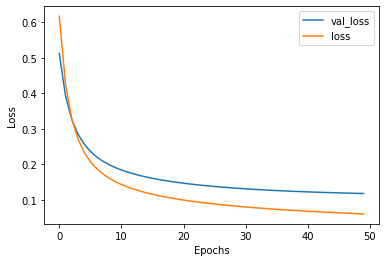

In [13]:
avg_loss = []
val_losses = []
parameters = initialize_weights_and_biases(layer_sizes)

num_steps = len(x_train) // batch_size

for epoch in range(1,epochs+1):
    
    losses = []
    for step in range(0,num_steps):
        batch_x = x_train[step*batch_size: (step+1)*batch_size] 
        batch_y = y_train[step*batch_size: (step+1)*batch_size] 

        y_hat, memory_list = forward_pass(batch_x, parameters)
        loss = compute_loss(y_hat, batch_y)
        losses.append(loss)
        gradients = backpropagate(memory_list, batch_y, y_hat)

        parameters = update_parameters(gradients, parameters, learning_rate)


    avg_loss.append(np.average(losses))
            
    y_hat, memory_list = forward_pass(x_val, parameters)
    val_loss = compute_loss(y_hat, y_val)
    val_losses.append(val_loss)
    val_accuracy = accuracy(y_val, predict(x_val, parameters))
    
    print("epoch %i,   Validation Loss %f, Validation Accuracy: %f" %(epoch, val_loss, val_accuracy))
        
plt.plot(val_losses, label = "val_loss")
plt.plot(avg_loss, label = "loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()